In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
import torchvision
import math
from PIL import Image
from math import floor
from sklearn.preprocessing import MultiLabelBinarizer
import os
from scipy.ndimage.interpolation import rotate
import types
import numbers
import random
%matplotlib inline

In [2]:
PRE_TRAINED_RESNET18 = 2
RELOAD = False
EPOCHS = 0
PATIENCE = 5
initial_lr = 0.0001

In [3]:
csv_data = pd.read_csv("train_v2.csv")

In [4]:
def train_valid_split(dataframe, test_size = 0.25, shuffle = False, random_seed = 0):
    """ Return a list of splitted indices from a DataSet.
    Indices can be used with DataLoader to build a train and validation set.
    
    Arguments:
        A Dataframe
        A test_size, as a float between 0 and 1 (percentage split) or as an int (fixed number split)
        Shuffling True or False
        Random seed
    """
    length = len(dataframe)
    indices = list(range(1,length))
    
    if shuffle == True:
        random.seed(random_seed)
        random.shuffle(indices)
    
    if type(test_size) is float:
        split = floor(test_size * length)
    elif type(test_size) is int:
        split = test_size
    else:
        raise ValueError('%s should be an int or a float' % str)
    return indices[split:], indices[:split]

In [5]:
class KaggleAmazonDataset(Dataset):
    """Dataset wrapping images and target labels for Kaggle - Planet Amazon from Space competition.

    Arguments:
        A CSV file path
        Path to image folder
        Extension of images
        PIL transforms
    """

    def __init__(self, csv_path, img_path, img_ext, transform=None):
    
        tmp_df = pd.read_csv(csv_path)
        assert tmp_df['image_name'].apply(lambda x: os.path.isfile(img_path + x + img_ext)).all(), \
"Some images referenced in the CSV file were not found"
        
        self.mlb = MultiLabelBinarizer()
        self.img_path = img_path
        self.img_ext = img_ext
        self.transform = transform

        self.X_train = tmp_df['image_name']
        self.y_train = self.mlb.fit_transform(tmp_df['tags'].str.split()).astype(np.float32)

    def __getitem__(self, index):
        img = Image.open(self.img_path + self.X_train[index] + self.img_ext)
        img = img.convert('RGB')
        if self.transform is not None:
            img = self.transform(img).cuda()
        
        label = torch.from_numpy(self.y_train[index]).cuda()
        return img, label

    def __len__(self):
        return len(self.X_train.index)

In [6]:
class Lambda(object):
    """Apply a user-defined lambda as a transform.

    Args:
        lambd (function): Lambda/function to be used for transform.
    """

    def __init__(self, lambd):
        assert isinstance(lambd, types.LambdaType)
        self.lambd = lambd

    def __call__(self, img):
        return self.lambd(img)
    
    
class RandomRotation(object):
    """Rotate the image by angle.

    Args:
        degrees (sequence or float or int): Range of degrees to select from.
            If degrees is a number instead of sequence like (min, max), the range of degrees
            will be (-degrees, +degrees).
        resample ({PIL.Image.NEAREST, PIL.Image.BILINEAR, PIL.Image.BICUBIC}, optional):
            An optional resampling filter.
            See http://pillow.readthedocs.io/en/3.4.x/handbook/concepts.html#filters
            If omitted, or if the image has mode "1" or "P", it is set to PIL.Image.NEAREST.
        expand (bool, optional): Optional expansion flag.
            If true, expands the output to make it large enough to hold the entire rotated image.
            If false or omitted, make the output image the same size as the input image.
            Note that the expand flag assumes rotation around the center and no translation.
        center (2-tuple, optional): Optional center of rotation.
            Origin is the upper left corner.
            Default is the center of the image.
    """

    def __init__(self, degrees, resample=False, expand=False, center=None):
        if isinstance(degrees, numbers.Number):
            if degrees < 0:
                raise ValueError("If degrees is a single number, it must be positive.")
            self.degrees = (-degrees, degrees)
        else:
            if len(degrees) != 2:
                raise ValueError("If degrees is a sequence, it must be of len 2.")
            self.degrees = degrees

        self.resample = resample
        self.expand = expand
        self.center = center

    @staticmethod
    def get_params(degrees):
        """Get parameters for ``rotate`` for a random rotation.

        Returns:
            sequence: params to be passed to ``rotate`` for random rotation.
        """
        angle = np.random.uniform(degrees[0], degrees[1])

        return angle

    def __call__(self, img):
        """
            img (PIL Image): Image to be rotated.

        Returns:
            PIL Image: Rotated image.
        """

        angle = self.get_params(self.degrees)

        return rotate(img, angle, reshape=False)

class RandomVerticalFlip(object):
    """Vertically flip the given PIL Image randomly with a probability of 0.5."""

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be flipped.

        Returns:
            PIL Image: Randomly flipped image.
        """
        if random.random() < 0.5:
            return np.flip(img,1)
        return img

In [7]:

IMG_PATH = '/media/train-jpg/'
IMG_EXT = '.jpg'
TRAIN_DATA = 'train_v2.csv'
TEST_DATA = './test/test.csv'
IMG_TEST_PATH = './test/'
# Data augmentation
ds_transform_augmented = transforms.Compose([
                 #transforms.RandomSizedCrop(224),
                 transforms.Scale(224),
                 transforms.RandomHorizontalFlip(),
                 RandomVerticalFlip(),
                 RandomRotation(10),
                 #ColorJitter(0.5,0.5,0.5,0.5),
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
                ])

## Normalization only for validation and test
ds_transform_raw = transforms.Compose([
                 transforms.Scale(224),
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.02, 0.02, 0.225])
                 ])



X_train = KaggleAmazonDataset(TRAIN_DATA,IMG_PATH,IMG_EXT,
                             ds_transform_augmented
                             )
#X_val = KaggleAmazonDataset(TRAIN_DATA,IMG_PATH,IMG_EXT,
#                             ds_transform_raw
#                             )
X_test = KaggleAmazonDataset(TEST_DATA,IMG_TEST_PATH,IMG_EXT,transforms.Compose([transforms.ToTensor()]))


/home/diego/.conda/envs/pytorch/lib/python3.6/site-packages/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [8]:
# Creating a validation split
train_idx, valid_idx = train_valid_split(X_train, 0.2)

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(X_train,
                          batch_size=45,
                          sampler=train_sampler,
                          #num_workers=4,
                          #pin_memory= True
                         )

valid_loader = DataLoader(X_train,
                          batch_size=45,
                          sampler=valid_sampler,
                          #num_workers=4,
                         #pin_memory= True
                         )

test_loader = DataLoader(X_test,batch_size=5)

In [9]:
def adaptive_avgmax_pool2d(x, pool_type='avg', padding=0, count_include_pad=False):
    """Selectable global pooling function with dynamic input kernel size
    """
    if pool_type == 'avgmaxc':
        x = torch.cat([
            F.avg_pool2d(
                x, kernel_size=(x.size(2), x.size(3)), padding=padding, count_include_pad=count_include_pad),
            F.max_pool2d(x, kernel_size=(x.size(2), x.size(3)), padding=padding)
        ], dim=1)
    elif pool_type == 'avgmax':
        x_avg = F.avg_pool2d(
                x, kernel_size=(x.size(2), x.size(3)), padding=padding, count_include_pad=count_include_pad)
        x_max = F.max_pool2d(x, kernel_size=(x.size(2), x.size(3)), padding=padding)
        x = 0.5 * (x_avg + x_max)
    elif pool_type == 'max':
        x = F.max_pool2d(x, kernel_size=(x.size(2), x.size(3)), padding=padding)
    else:
        if pool_type != 'avg':
            print('Invalid pool type %s specified. Defaulting to average pooling.' % pool_type)
        x = F.avg_pool2d(
            x, kernel_size=(x.size(2), x.size(3)), padding=padding, count_include_pad=count_include_pad)
    return x

class AdaptiveAvgMaxPool2d(torch.nn.Module):
    """Selectable global pooling layer with dynamic input kernel size
    """
    def __init__(self, output_size=1, pool_type='avg'):
        super(AdaptiveAvgMaxPool2d, self).__init__()
        self.output_size = output_size
        self.pool_type = pool_type
        if pool_type == 'avgmaxc' or pool_type == 'avgmax':
            self.pool = nn.ModuleList([nn.AdaptiveAvgPool2d(output_size), nn.AdaptiveMaxPool2d(output_size)])
        elif pool_type == 'max':
            self.pool = nn.AdaptiveMaxPool2d(output_size)
        else:
            if pool_type != 'avg':
                print('Invalid pool type %s specified. Defaulting to average pooling.' % pool_type)
            self.pool = nn.AdaptiveAvgPool2d(output_size)

    def forward(self, x):
        if self.pool_type == 'avgmaxc':
            x = torch.cat([p(x) for p in self.pool], dim=1)
        elif self.pool_type == 'avgmax':
            x = 0.5 * torch.sum(torch.stack([p(x) for p in self.pool]), 0).squeeze(dim=0)
        else:
            x = self.pool(x)
        return x

    def factor(self):
        return pooling_factor(self.pool_type)

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + 'output_size=' + str(self.output_size) \
+ ', pool_type=' + self.pool_type + ')'

def pooling_factor(pool_type='avg'):
    return 2 if pool_type == 'avgmaxc' else 1

__all__ = ['ResNet', 'resnet18']

model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth'
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, drop_rate=0.0):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
        self.drop_rate = drop_rate

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        if self.drop_rate > 0.:
            out = F.dropout(out, p=self.drop_rate, training=self.training)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, drop_rate=0.0):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.drop_rate = drop_rate

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        if self.drop_rate > 0.:
            out = F.dropout(out, p=self.drop_rate, training=self.training)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000,
                 drop_rate=0.0, block_drop_rate=0.0,
                 global_pool='avg'):
        self.inplanes = 64
        self.drop_rate = drop_rate
        self.expansion = block.expansion
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], drop_rate=block_drop_rate)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, drop_rate=block_drop_rate)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, drop_rate=block_drop_rate)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, drop_rate=block_drop_rate)
        self.global_pool = AdaptiveAvgMaxPool2d(pool_type=global_pool)
        self.fc = nn.Linear(512 * block.expansion * self.global_pool.factor(), num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, drop_rate=0.):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = [block(self.inplanes, planes, stride, downsample, drop_rate)]
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def get_fc(self):
        return self.fc

    def reset_fc(self, num_classes, global_pool='avg'):
        self.global_pool = AdaptiveAvgMaxPool2d(pool_type=global_pool)
        self.fc = nn.Linear(512 * self.expansion * self.global_pool.factor(), num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)

        if self.drop_rate > 0.:
            x = F.dropout(x, p=self.drop_rate, training=self.training)

        x = self.fc(x)
        return x

def resnet18(pretrained=True, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model

    
def resnet18_fc(num_classes, pretrained, embedding_len, bn, dp=False):
    "resnet18 + FC layer embedding"
    model = resnet18(num_classes)
    if pretrained:
        model = torch.nn.DataParallel(model)  # due to saving parallel table
        checkpoint = torch.load(PRE_TRAINED_RESNET18)
        model.load_state_dict(checkpoint['state_dict'])
        model = model.module

    model.fc1 = nn.Linear(512, embedding_len)
    model.relu_fc1 = nn.ReLU(inplace=True) #new
    model.fc = nn.Linear(embedding_len, num_classes)
    if bn:
        model.fc_bn = nn.BatchNorm1d(embedding_len)

    if dp:
        model.dp = nn.Dropout2d(p=0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        if x.size(2) != 1:
            x = F.avg_pool2d(x, x.size(2))
        x = x.view(x.size(0), -1)
        x = self.relu_fc1(self.fc1(x))

        if getattr(self, 'fc_bn', None) is not None:
            x = self.fc_bn(x)
        if getattr(self, 'dp', None) is not None:
            x = self.dp(x)
        x = self.fc(x)

        return x

    setattr(model.__class__, 'forward', forward)

    layers = [model.fc1, model.fc, model.avgpool, model.layer4, model.layer3]

    return model, layers

def resnet18_fc128(num_classes=17, pretrained=False, bn=False):
    "0.08693 loss, LB: 0.92047"
    return resnet18_fc(num_classes, pretrained, embedding_len=128, bn=False)

In [10]:
model = resnet18(pretrained=True)
model.reset_fc(17)
optimizer = optim.SGD(model.get_fc().parameters(), lr=initial_lr, momentum=0.9)
#optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=0.9)
criterion = nn.MultiLabelSoftMarginLoss()
criterion.cuda()

MultiLabelSoftMarginLoss (
)

In [11]:
from sklearn.metrics import fbeta_score

best_accuracy = 0.0
current_patience = PATIENCE

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    return fbeta_score(output, target, beta=2, average="samples")

def train_generator(model,epoch,train_loader,optimizer,criterion):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.cuda(async=True), target.cuda(async=True) # On GPU
            data, target = Variable(data), Variable(target)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 1000 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.data[0]))
                
def test_generator(model, val_loader, criterion, final_test = False):
        global current_patience
        global best_accuracy
        model.eval()
        test_loss = 0
        ammount = 0
        equal = 0
        pred_all = None
        test_all = None
        for data, target in val_loader:
            data, target = data.cuda(async=True), target.cuda(async=True) # On GPU
            data, target = Variable(data.float(), volatile=True), Variable(target.float())
            output = model(data)
            ammount += len(data)
            test_loss += criterion(output, target).data[0]
            pred = output
            #print(pred)
            pred[pred > 0.1] = 1
            pred[pred != 1] = 0

            if type(pred_all) == type(None):
                pred_all = pred.cpu().data.numpy().astype(np.uint8)
            else:
                pred = pred.cpu().data.numpy().astype(np.uint8)

                pred_all = np.concatenate((pred_all,pred),axis=0)
            if type(test_all) == type(None):
                test_all = target.cpu().data.numpy().astype(np.uint8)
            else:
                target = target.cpu().data.numpy().astype(np.uint8)
                test_all = np.concatenate((test_all,target),axis=0)
            #accuracy(output, target,topk=(1,3))
        accur = accuracy(pred_all,test_all)
        
        # Save the model or early stop
        if accur > best_accuracy:
            torch.save(model.state_dict(), "resnet18-%s.pth" % int(accur*100))
            best_accuracy = accur
            current_patience = PATIENCE
        else:
            if current_patience < 1:
                return False
            else:
                current_patience -= 1
            
        test_loss /= ammount
        print('Test set: Accuracy: %s  /  Patience: %s\n' % (accur,current_patience))
        
        return True

In [ ]:
#model = torch.nn.DataParallel(model).cuda()

if RELOAD:
    model.load_state_dict(torch.load("resnet18-85.pth"))

for epoch in range(1, EPOCHS + 1):
    
    train_generator(model,epoch,train_loader,optimizer,criterion)
    
    if not test_generator(model,valid_loader,criterion):
        break
        
    # Adjust lr
    for param_group in optimizer.param_groups:
        param_group['lr']=initial_lr * (0.1 ** (epoch // EPOCHS))

In [22]:
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load("resnet18-90.pth"))

model = torch.nn.DataParallel(model).cuda()


def final_test_generator(model, val_loader, criterion, final_test = False):

        model.eval()
        test_loss = 0
        ammount = 0
        equal = 0
        pred_all = None
        test_all = None
        for data, target in val_loader:
            data, target = data.cuda(async=True), target.cuda(async=True) # On GPU
            data, target = Variable(data.float(), volatile=True), Variable(target.float())
            output = model(data)
            pred = output
            pred[pred > 0.1] = 1
            pred[pred != 1] = 0
            print(target)
        return pred

pred = final_test_generator(model,test_loader,criterion)
pred = pred.cpu().data.numpy()

KeyError: 'unexpected key "module.conv1.weight" in state_dict'

array(['cloudy'], dtype=object)

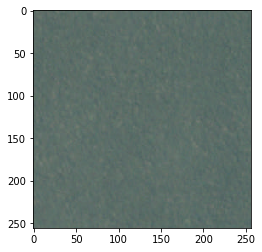

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img0 = mpimg.imread("./test/train_0.jpg")
plt.imshow(img0)
X_train.mlb.classes_[pred[0].astype(bool)]

array(['primary'], dtype=object)

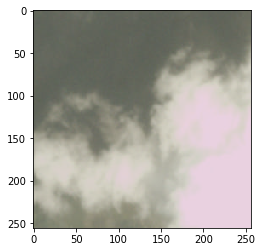

In [19]:
img1 = mpimg.imread("./test/train_12.jpg")
plt.imshow(img1)
X_train.mlb.classes_[pred[1].astype(bool)]

array(['clear', 'primary', 'water'], dtype=object)

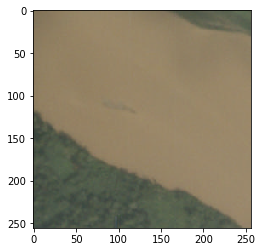

In [20]:
img2 = mpimg.imread("./test/train_30.jpg")
plt.imshow(img2)
X_train.mlb.classes_[pred[2].astype(bool)]

array(['primary'], dtype=object)

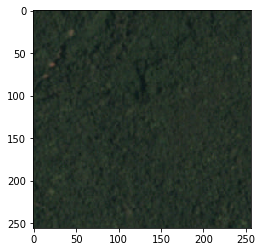

In [21]:
img3 = mpimg.imread("./test/train_38.jpg")
plt.imshow(img3)
X_train.mlb.classes_[pred[3].astype(bool)]